In [ ]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

In [ ]:
#DATA_DIR = 'data/'
#x_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'SVI2018_US_COUNTY.csv'), delimiter=',', skiprows=1)

data_svi2018_us_per_county = pd.read_csv("data/SVI2018_US_COUNTY.csv") 
data_svi2018_us_per_county.head()

In [129]:
data_covid_cases_deaths_county = pd.read_csv("data/covid_cases_deaths_county.csv", dtype={"fips": str}, parse_dates=['date']) 
data_covid_cases_deaths_county.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [63]:
np.count_nonzero(np.asarray([data_covid_cases_deaths_county['deaths']>10000.0]))


323

In [64]:
rslt_df = data_covid_cases_deaths_county[data_covid_cases_deaths_county['date'] == '2021-01-20']
  
rslt_df

,date,county,state,fips,cases,deaths
946480,2021-01-20,Autauga,Alabama,01001,5257,55.0
946481,2021-01-20,Baldwin,Alabama,01003,16653,184.0
946482,2021-01-20,Barbour,Alabama,01005,1760,36.0
946483,2021-01-20,Bibb,Alabama,01007,2188,47.0
946484,2021-01-20,Blount,Alabama,01009,5376,83.0
...,...,...,...,...,...,...
949721,2021-01-20,Sweetwater,Wyoming,56037,3347,28.0
949722,2021-01-20,Teton,Wyoming,56039,2788,5.0
949723,2021-01-20,Uinta,Wyoming,56041,1852,10.0
949724,2021-01-20,Washakie,Wyoming,56043,845,24.0


In [65]:
data_covid_cases_deaths_county['date']

0        2020-01-21
1        2020-01-22
2        2020-01-23
3        2020-01-24
4        2020-01-24
            ...    
978926   2021-01-29
978927   2021-01-29
978928   2021-01-29
978929   2021-01-29
978930   2021-01-29
Name: date, Length: 978931, dtype: datetime64[ns]

# GNNs

In [209]:
fst_day = max(data_covid_cases_deaths_county['date']) # the earliest day in the dataset
fst_day

Timestamp('2021-01-29 00:00:00')

In [210]:
rslt_fst_day_df = data_covid_cases_deaths_county[data_covid_cases_deaths_county['date'] == fst_day]
rslt_fst_day_df

,date,county,state,fips,cases,deaths
975686,2021-01-29,Autauga,Alabama,01001,5596,69.0
975687,2021-01-29,Baldwin,Alabama,01003,17922,224.0
975688,2021-01-29,Barbour,Alabama,01005,1931,40.0
975689,2021-01-29,Bibb,Alabama,01007,2284,51.0
975690,2021-01-29,Blount,Alabama,01009,5655,98.0
...,...,...,...,...,...,...
978926,2021-01-29,Sweetwater,Wyoming,56037,3464,32.0
978927,2021-01-29,Teton,Wyoming,56039,3078,6.0
978928,2021-01-29,Uinta,Wyoming,56041,1959,12.0
978929,2021-01-29,Washakie,Wyoming,56043,863,25.0


In [211]:
unique_fips_fst_day = np.asarray([fips for fips in rslt_fst_day_df['fips'].unique()])
print(unique_fips_fst_day.shape)
unique_fips_fst_day= np.asarray([x for x in unique_fips_fst_day if str(x) != 'nan']) # converting to int and removing nans
print(unique_fips_fst_day.shape)

(3219,)
(3218,)


In [212]:
unique_fips_fst_day

array(['01001', '01003', '01005', ..., '56041', '56043', '56045'],
      dtype='<U5')

In [213]:
# now adding a column with integer identificator starting from 0
ids_nodes = np.arange(unique_fips_fst_day.shape[0])
ids_nodes

array([   0,    1,    2, ..., 3215, 3216, 3217])

In [214]:
death_per_county = list()
for _id in unique_fips_fst_day:
    n_deaths = rslt_fst_day_df.loc[rslt_fst_day_df['fips'] == _id, 'deaths']
    if (n_deaths.shape[0] == 0):
        death_per_county.append(0.0)
    else:
        death_per_county.append(n_deaths.to_numpy()[0])
            

death_per_county = np.asarray(death_per_county, dtype = np.float64)
death_per_county

array([ 69., 224.,  40., ...,  12.,  25.,   4.])

In [215]:
rslt_fst_day_df.loc[rslt_fst_day_df['fips'] == '1001', 'deaths']

Series([], Name: deaths, dtype: float64)

In [216]:
# change fips to be ints instead of strings so we can better manage the edges later
unique_fips_fst_day = unique_fips_fst_day.astype(np.int64)
unique_fips_fst_day

array([ 1001,  1003,  1005, ..., 56041, 56043, 56045])

In [217]:
# now we can put together id, fips and deaths in a dataframe
stack = np.hstack([ids_nodes.reshape((ids_nodes.shape[0],1)), unique_fips_fst_day.reshape((ids_nodes.shape[0],1)), death_per_county.reshape((ids_nodes.shape[0],1))])

In [218]:
stack.shape

(3218, 3)

In [219]:
ids_nodes.reshape((ids_nodes.shape[0],1))

array([[   0],
       [   1],
       [   2],
       ...,
       [3215],
       [3216],
       [3217]])

In [220]:
nodes_df = pd.DataFrame(data=stack, columns=["id", "fips", "deaths"])
print(nodes_df)

          id     fips  deaths
0        0.0   1001.0    69.0
1        1.0   1003.0   224.0
2        2.0   1005.0    40.0
3        3.0   1007.0    51.0
4        4.0   1009.0    98.0
...      ...      ...     ...
3213  3213.0  56037.0    32.0
3214  3214.0  56039.0     6.0
3215  3215.0  56041.0    12.0
3216  3216.0  56043.0    25.0
3217  3217.0  56045.0     4.0

[3218 rows x 3 columns]


In [221]:
# so the above is the data we are going to use for our nodes (1st layer).
# now let's construct the edges data. We will take it from the counties adjacency data

county_adjacency_df = pd.read_csv("data/county_adjacency2010.csv", dtype={"fips": str}) 
county_adjacency_df

,countyname,fipscounty,neighborname,fipsneighbor
0,"Autauga County, AL",1001,"Autauga County, AL",1001
1,"Autauga County, AL",1001,"Chilton County, AL",1021
2,"Autauga County, AL",1001,"Dallas County, AL",1047
3,"Autauga County, AL",1001,"Elmore County, AL",1051
4,"Autauga County, AL",1001,"Lowndes County, AL",1085
...,...,...,...,...
22195,"St. Croix Island, VI",78010,"St. Croix Island, VI",78010
22196,"St. John Island, VI",78020,"St. John Island, VI",78020
22197,"St. John Island, VI",78020,"St. Thomas Island, VI",78030
22198,"St. Thomas Island, VI",78030,"St. John Island, VI",78020


In [222]:
county_adjacency_only_fips = county_adjacency_df[["fipscounty", "fipsneighbor"]]

In [233]:
# select only the edges that are linking two different loops (we're avoiding loops)
county_adjacency_only_fips = county_adjacency_only_fips[county_adjacency_only_fips['fipscounty'] != county_adjacency_only_fips['fipsneighbor']]
county_adjacency_only_fips

,fipscounty,fipsneighbor
1,1001,1021
2,1001,1047
3,1001,1051
4,1001,1085
5,1001,1101
...,...,...
22191,72153,72081
22192,72153,72093
22193,72153,72121
22197,78020,78030


In [236]:
fipscouty = county_adjacency_only_fips['fipscounty'].to_numpy()
fipscouty.shape

(18966,)

In [237]:
fipsneighbor = county_adjacency_only_fips['fipsneighbor'].to_numpy()
fipsneighbor.shape

(18966,)

In [240]:
# associating the ids to the source and destination nodes that we assigned when creating the nodes dataframe
ids_src_nodes = list()
ids_dst_nodes = list()
for i in range(fipscouty.shape[0]):
    id_to_append_src = nodes_df.loc[nodes_df['fips'] == fipscouty[i], 'id'].to_numpy()
    id_to_append_dst = nodes_df.loc[nodes_df['fips'] == fipsneighbor[i], 'id'].to_numpy()
    
    if (id_to_append_src.shape[0] != 0 and id_to_append_dst.shape[0] != 0):
        ids_src_nodes.append(id_to_append_src[0])
        ids_dst_nodes.append(id_to_append_dst[0])
    
print(ids_src_nodes)
print('--')
print(ids_dst_nodes)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 28.0, 28.0, 28.0, 28.0, 28.0, 29.0, 29.0, 29

In [249]:
ids_src_nodes = np.asarray(ids_src_nodes, dtype=np.int64)
ids_dst_nodes = np.asarray(ids_dst_nodes, dtype=np.int64)

stack_edges = np.hstack([ids_src_nodes.reshape((ids_src_nodes.shape[0],1)), ids_dst_nodes.reshape((ids_dst_nodes.shape[0],1))])
edges_df = pd.DataFrame(data=stack_edges, columns=["src", "dst"])
edges_df

,src,dst
0,0,10
1,0,23
2,0,25
3,0,42
4,0,50
...,...,...
18885,2383,2347
18886,2383,2353
18887,2383,2367
18888,2894,2895


In [250]:
# we have fewer numbers since there were counties ids in the adjacency dataframe that didn't match any county in
# the nodes dataset

In [251]:
import torch
import dgl

# now let's create the dgl graph
src = edges_df['src'].to_numpy()
dst = edges_df['dst'].to_numpy()

# Create a DGL graph from a pair of numpy arrays
g = dgl.graph((src, dst))

# Print a graph gives some meta information such as number of nodes and edges.
print(g)

Graph(num_nodes=3218, num_edges=18890,
      ndata_schemes={}
      edata_schemes={})


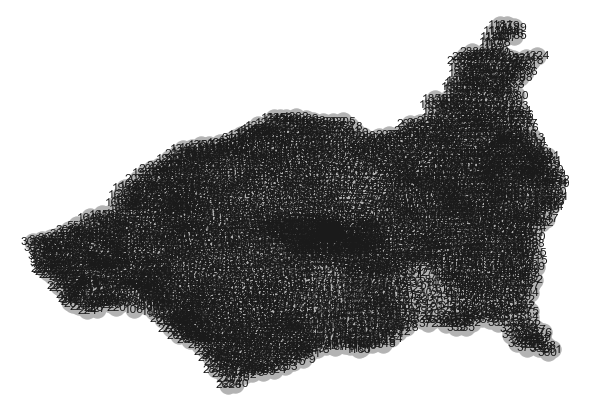

In [252]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_g = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])